## Import Libraries
The code used to implement the TD3 agent is taken from here: https://github.com/higgsfield/RL-Adventure-2.

In [1]:
import math
import random
import time
import pandas as pd

from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
use_cuda

False

## Plot Functions

In [2]:
plt.rcParams.update({'font.size': 18})
def plot_rewards(rewards):
    plt.plot(range(len(rewards)), rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.show()
    plt.close()

def plot_smoothed(rewards, a):
    rewards_ema = pd.DataFrame(rewards).ewm(alpha = a).mean()
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.plot(rewards_ema)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards (EMA)")
    plt.show()
    plt.close()

def plot_eps(eps):
    plt.plot(range(len(eps)), eps)
    plt.xlabel("Episodes")
    plt.ylabel("Number of Steps")
    plt.show()
    plt.close()

## Save gifs of agent

In [3]:
def save_frames_as_gif(frames, path='./Visualizations/LunarLander/gifs/FROMP/', filename='pendulum_gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='pillow', fps= 120)

## Create log(cosh) loss

In [4]:
def log_cosh(x):
    return x + torch.nn.functional.softplus(-2. * x) - math.log(2.0)

def log_cosh_loss(y_pred, y_true, reduction = 'mean'):
    if reduction is not None:
        return torch.mean(log_cosh(y_pred - y_true))
    else:
        return log_cosh(y_pred - y_true)

class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_pred, y_true, reduction = 'mean'):
        return log_cosh_loss(y_pred, y_true, reduction)

## Replay Buffer

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        # Add space in buffer to add next tuple
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        # Add tuple to buffer
        self.buffer[self.position] = (state, action, reward, next_state, done)
        # Cycle index to beginning once buffer is full
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # Creates a tuple of 5 elements: states, actions, ...., dones
        # Each element is an array of length = batch_size
        # i.e. first element is an array of states, second is an array of actions, etc
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

## Normalize action space

In [6]:
class NormalizedActions(gym.ActionWrapper):

    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        
        return action

## Gaussian Noise

In [7]:
class GaussianExploration(object):
    def __init__(self, action_space, max_sigma=1.0, min_sigma=1.0, decay_period=1000000):
        self.low  = action_space.low
        self.high = action_space.high
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
    
    def get_action(self, action, t=0):
        sigma  = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        action = action + np.random.normal(size=len(action)) * sigma
        # Output: array([action])
        return np.clip(action, self.low, self.high)

## Soft Update Function for Targets

In [8]:
def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

## Define Actor and Critic Networks

In [9]:
# Critic
class ValueNetwork(nn.Module):
    def __init__(self, seed, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    
# Actor
class PolicyNetwork(nn.Module):
    def __init__(self, seed, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        # [0] extracts [action] from array([[action]])
        return action.detach().cpu().numpy()[0]

## Create Memorable Points Buffer

In [10]:
class Memory(dict):
    ''' 
    Memory is a nested dictionary
    keys are task indicators
    items are sorted dictionarys with keys that are hessian values and items that are memorable pts
    '''
    
    def __init__(self, capacity = 1000, n_tasks = None):
        super(Memory, self).__init__()
        self.capacity = capacity
        # Initialize sorted dictionary for each task
        if n_tasks is not None:
            for i in range(n_tasks):
                self[i + 1] = {}
            
    def add_task(self, task):
        self[task] = {}
                
    def add(self, task, key, items, minHess):
        cur_mem = self[task]
        # If memory not yet full
        if len(cur_mem) < self.capacity:
            # Add new memorable pt
            cur_mem[key.item()] = items
        else:
            # If given Hessian greater than min Hessian in memory
            if key > minHess:
                # Remove memorable pt with min Hessian
                cur_mem.pop(minHess)
                cur_mem[key.item()] = items
        # Return new min Hessian
        return min(cur_mem.keys())
            

## Create Regularizer and Hessian Function

In [11]:
def calc_reg(cur, mem_pts, prev, is_policy):
    '''
    Function to calculate regularizer term
    cur: current model f_t
    mem_pts: memorable points (nested dictionary)
    prev: previous model f_{t - 1}
    '''
    reg_term = 0
    n = len(mem_pts.keys())
    # Loop through all but current task
    for i in range(n - 1):
        cur_mem = mem_pts[i + 1]
        mem_states = torch.cat([obs[0] for obs in cur_mem.values()]).to(device)
        mem_actions = torch.cat([obs[1] for obs in cur_mem.values()]).to(device)
        if is_policy:
            f_t = cur(mem_states)
            f_t_1 = prev(mem_states)
        else:
            f_t = cur(mem_states, mem_actions)
            f_t_1 = prev(mem_states, mem_actions)
        reg_term += torch.sum((f_t - f_t_1)**2)
    return reg_term

def hessian(y):
    '''
    Function to calculate hessian: sech**2(y)
    y: loss tensor
    '''
    return 1 / torch.cosh(y)**2

## TD3 Update

In [12]:
def td3_update(step,
           batch_size,
           replay_buffer,
           first_task,
           mem_pts,
           prev_Q = None,
           prev_policy = None,   
           delta = 1e-3,
           delta_policy = 1e2,
           gamma = 0.99,
           soft_tau=1e-2,
           noise_std = 0.2,
           noise_clip=0.5,
           policy_update=2,
          ):

    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    # Converts to tensor and adds extra dimension
    # i.e. tensor([[r_1], [r_2], ..., [r_n]])
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    # Converts dones to floats and does same conversion as rewards
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    # Select next action and add noise
    next_action = target_policy_net(next_state)
    noise = torch.normal(torch.zeros(next_action.size()), noise_std).to(device)
    noise = torch.clamp(noise, -noise_clip, noise_clip)
    next_action += noise

    # Calculate expected Q from target
    target_q_value1  = target_value_net1(next_state, next_action)
    target_q_value2  = target_value_net2(next_state, next_action)
    target_q_value   = torch.min(target_q_value1, target_q_value2)
    expected_q_value = reward + (1.0 - done) * gamma * target_q_value

    # Optimize critics
    q_value1 = value_net1(state, action)
    q_value2 = value_net2(state, action)

    value_loss1 = value_criterion(q_value1, expected_q_value.detach())
    value_loss2 = value_criterion(q_value2, expected_q_value.detach())
    value_loss_hess1 = value_criterion(q_value1.detach(), expected_q_value.detach(), reduction = None)
    value_loss_hess2 = value_criterion(q_value2.detach(), expected_q_value.detach(), reduction = None)
    
    # Calculate Hessians
    q_hess1, q_hess2 = hessian(value_loss_hess1), hessian(value_loss_hess2)
    # Calculates row-wise max hessian (think of q_hess1 and q_hess2 as columns)
    max_hess = torch.max(q_hess1, q_hess2)
    # ID of current task
    # Note: memorable pts buffer must be already defined for current task
    # outside of update function
    task_id = len(mem_pts.keys())
    cur_mem = mem_pts[task_id]
    minHess = 0
    if len(cur_mem.keys()) > 0:
        minHess = min(cur_mem.keys())
    Qreg_term1, Qreg_term2 = 0, 0
    
    # Add observations to memorable pts buffer
    for i in range(batch_size):
        vals = (state[i].unsqueeze(0), action[i].unsqueeze(0))
        # Note: add() filters the observations for memorable pts
        new_minHess = mem_pts.add(task_id, max_hess[i], vals, minHess)    
        minHess = new_minHess
        
    if not first_task:        
        # Calculate regularization terms
        Qreg_term1 = calc_reg(value_net1, mem_pts, prev_Q, False)
        Qreg_term2 = calc_reg(value_net2, mem_pts, prev_Q, False)
#     if step == 50:
#         print("Value Loss 1: ", value_loss1)
#         print("Regularizer 1: ", delta * Qreg_term1)
#         print("Value Loss 2: ", value_loss2)
#         print("Regularizer 2: ", delta * Qreg_term2)
        
    # Update loss
    value_loss1 += delta * Qreg_term1
    value_loss2 += delta * Qreg_term2

    value_optimizer1.zero_grad()
    value_loss1.backward()
    value_optimizer1.step()

    value_optimizer2.zero_grad()
    value_loss2.backward()
    value_optimizer2.step()

    # Update target and optimize policy every policy_update steps
    if step % policy_update == 0:
        policy_reg_term = 0
        if not first_task:
            policy_reg_term = calc_reg(policy_net, mem_pts, prev_policy, True)
        policy_loss = value_net1(state, policy_net(state))
        policy_loss = -policy_loss.mean()
#         if step == 50:
#             print("Policy Loss: ", policy_loss)
#             print("Regularizer: ", delta_policy * policy_reg_term)
        policy_loss += delta_policy * policy_reg_term

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        soft_update(value_net1, target_value_net1, soft_tau=soft_tau)
        soft_update(value_net2, target_value_net2, soft_tau=soft_tau)
        soft_update(policy_net, target_policy_net, soft_tau=soft_tau)

## Initialize Objects and Values

In [13]:
num_eps = 150
rewards = []
np.random.seed(24)
random.seed(24)
max_steps = 600
batch_size  = 128

# task1 = gym.make("LunarLander-v2", continuous = True, gravity = -5, enable_wind = True, wind_power = 20)
task1 = gym.make("LunarLander-v2", continuous = True)
task1.reset(seed = 24)
# Initialize noise with action space information
noise = GaussianExploration(task1.action_space)

state_dim  = task1.observation_space.shape[0]
action_dim = task1.action_space.shape[0]
hidden_dim = 256

seed1 = 24
seed2 = 8
seed3 = 17

value_net1 = ValueNetwork(seed1, state_dim, action_dim, hidden_dim).to(device)
value_net2 = ValueNetwork(seed2, state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(seed3, state_dim, action_dim, hidden_dim).to(device)

target_value_net1 = ValueNetwork(seed1, state_dim, action_dim, hidden_dim).to(device)
target_value_net2 = ValueNetwork(seed2, state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork(seed3, state_dim, action_dim, hidden_dim).to(device)

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(policy_net, target_policy_net, soft_tau=1.0)

value_criterion = LogCoshLoss()

policy_lr = 1e-3
value_lr  = 1e-3

value_optimizer1 = optim.Adam(value_net1.parameters(), lr=value_lr)
value_optimizer2 = optim.Adam(value_net2.parameters(), lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

## Task 1 (training)
Note: same replay buffer for all task during training
- Gravity: -10
- No wind

Episode:  0
Episode:  50
Episode:  100
Task 1 Training Complete


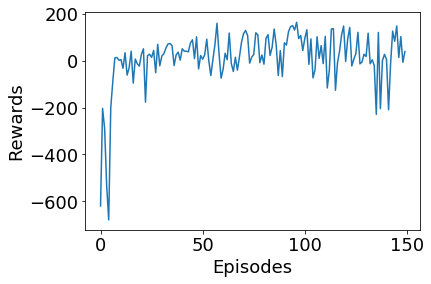

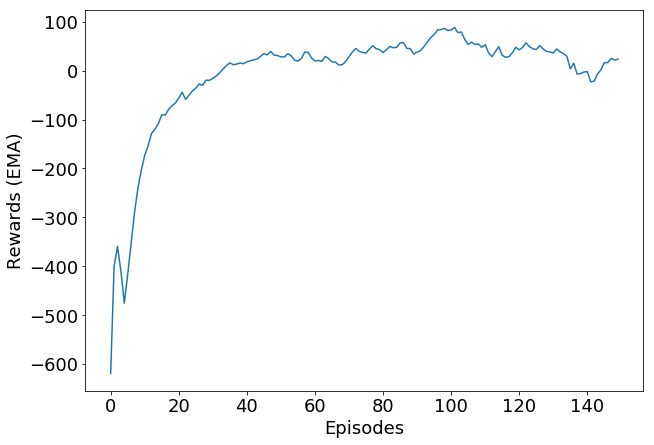

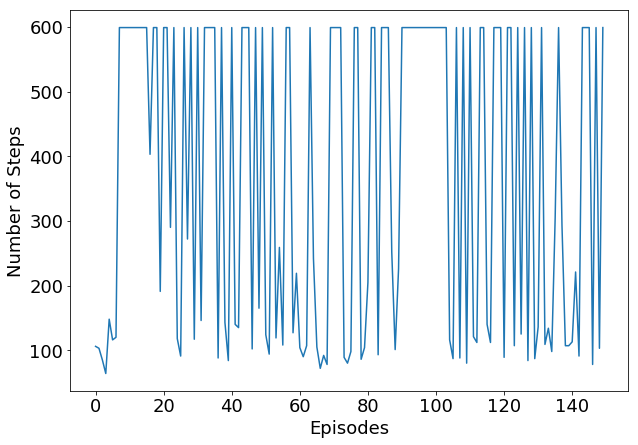

In [14]:
rewards_train = {}
rewards_test = {}
rewards_train['task1'] = []
eps = []
mem_pts = Memory(capacity = 32, n_tasks = 1)

replay_buffer_size = 10000
replay_buffer = ReplayBuffer(replay_buffer_size)

for ep in range(num_eps):
    if ep % 50 == 0:
        print("Episode: ", ep)
    state = task1.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = task1.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            td3_update(t, batch_size, replay_buffer, True, mem_pts)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break
    eps.append(t)

    rewards_train['task1'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed1, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed3, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net.state_dict())
prev_policy.eval()

print('Task 1 Training Complete')
rewards_task1 = rewards_train['task1']
plot_rewards(rewards_task1)
plot_smoothed(rewards_task1, 0.1)
plot_eps(eps)

## Task 2 (training)
- Gravity: -10
- Wind enabled

Episode:  0
Episode:  50
Episode:  100
Task 2 Training Complete


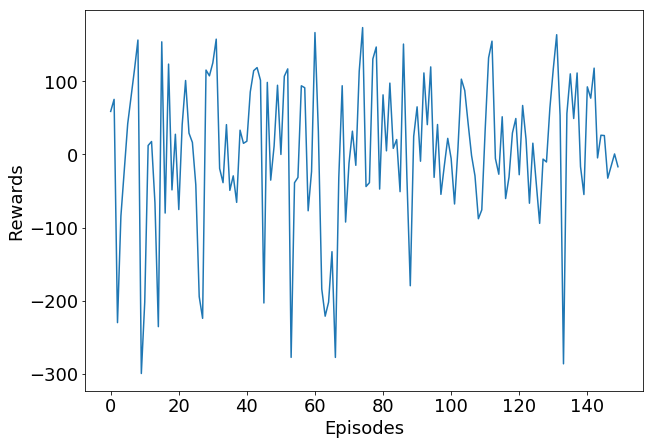

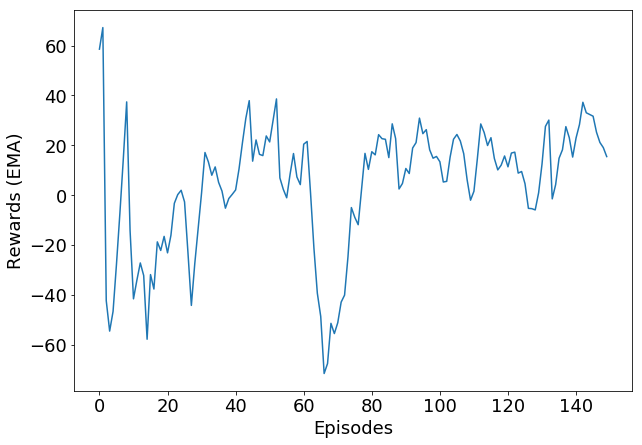

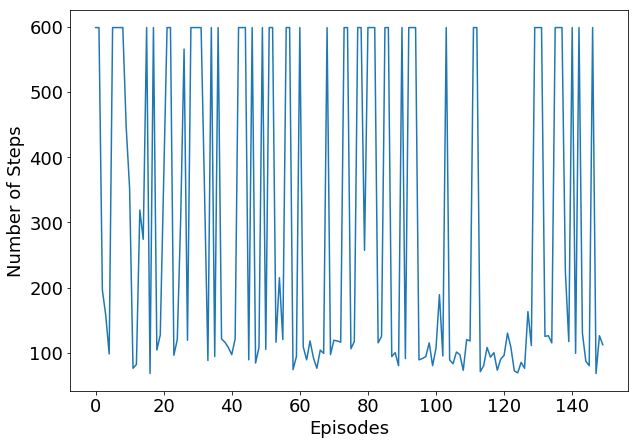

In [15]:
rewards_train['task2'] = []
mem_pts.add_task(2)
eps = []

task2 = gym.make("LunarLander-v2", continuous = True, enable_wind = True, wind_power = 20)
task2.reset(seed = 24)

for ep in range(num_eps):
    if ep % 50 == 0:
        print("Episode: ", ep)
    state = task2.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = task2.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            td3_update(t, batch_size, replay_buffer, False, mem_pts, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break
    eps.append(t)

    rewards_train['task2'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed1, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed3, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net.state_dict())
prev_policy.eval()

print('Task 2 Training Complete')
rewards_task2 = rewards_train['task2']
plot_rewards(rewards_task2)
plot_smoothed(rewards_task2, 0.1)
plot_eps(eps)

## Task 3 (training)
- Gravity: -7
- No wind

Episode:  0
Episode:  50
Episode:  100
Task 3 Training Complete


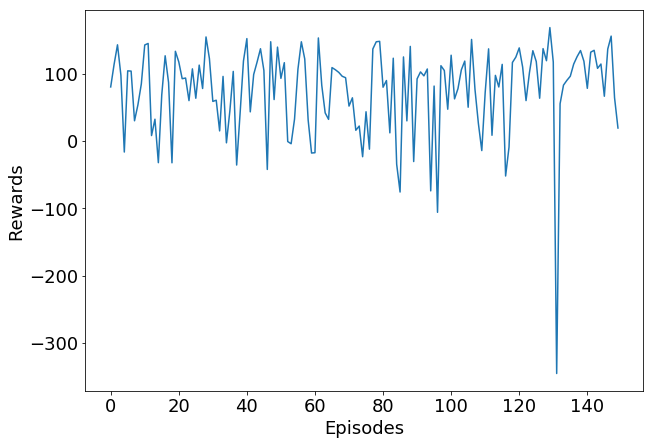

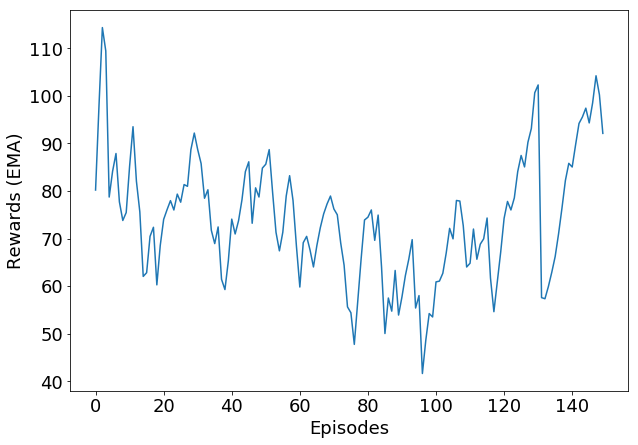

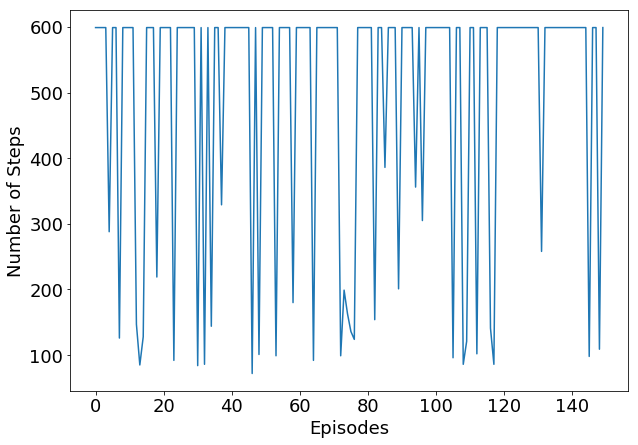

In [16]:
rewards_train['task3'] = []
eps = []
mem_pts.add_task(3)

task3 = gym.make("LunarLander-v2", continuous = True, gravity = -7)
task3.reset(seed = 24)

for ep in range(num_eps):
    if ep % 50 == 0:
        print("Episode: ", ep)
    state = task3.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = task3.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            td3_update(t, batch_size, replay_buffer, False, mem_pts, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break
    eps.append(t)

    rewards_train['task3'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed1, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed3, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net.state_dict())
prev_policy.eval()

print('Task 3 Training Complete')
rewards_task3 = rewards_train['task3']
plot_rewards(rewards_task3)
plot_smoothed(rewards_task3, 0.1)
plot_eps(eps)

## Task 4 (training)
- Gravity: -7
- Wind enabled

Episode:  0
Episode:  50
Episode:  100
Task 4 Training Complete


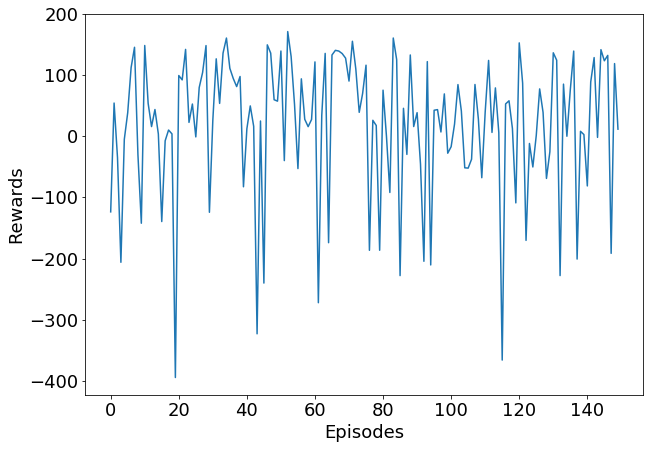

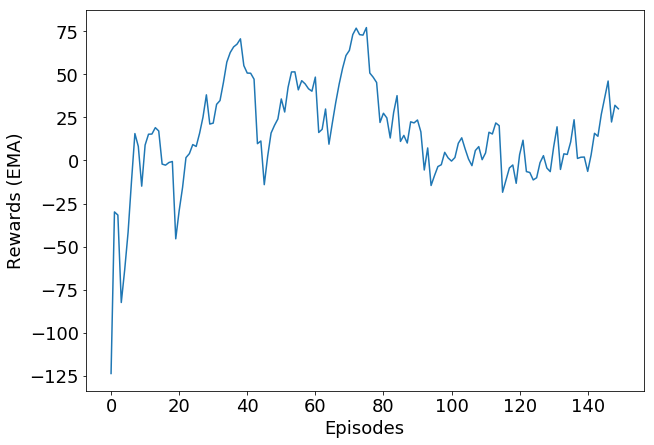

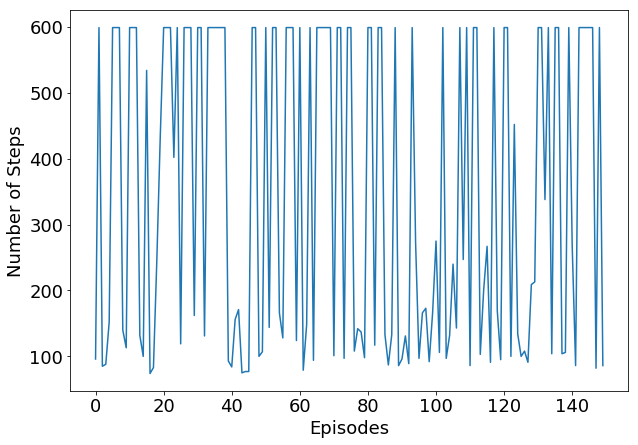

In [17]:
rewards_train['task4'] = []
eps = []
mem_pts.add_task(4)

task4 = gym.make("LunarLander-v2", continuous = True, gravity = -7, enable_wind = True, wind_power = 20)
task4.reset(seed = 24)

for ep in range(num_eps):
    if ep % 50 == 0:
        print("Episode: ", ep)
    state = task4.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = task4.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            td3_update(t, batch_size, replay_buffer, False, mem_pts, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break
    eps.append(t)

    rewards_train['task4'].append(ep_reward)
    
# Save models for next task
prev_Q = ValueNetwork(seed1, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed3, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net.state_dict())
prev_policy.eval()

print('Task 4 Training Complete')
rewards_task4 = rewards_train['task4']
plot_rewards(rewards_task4)
plot_smoothed(rewards_task4, 0.1)
plot_eps(eps)

## Task 5 (training)
- Gravity: -5
- No wind

Episode:  0
Episode:  50
Episode:  100
Task 5 Training Complete


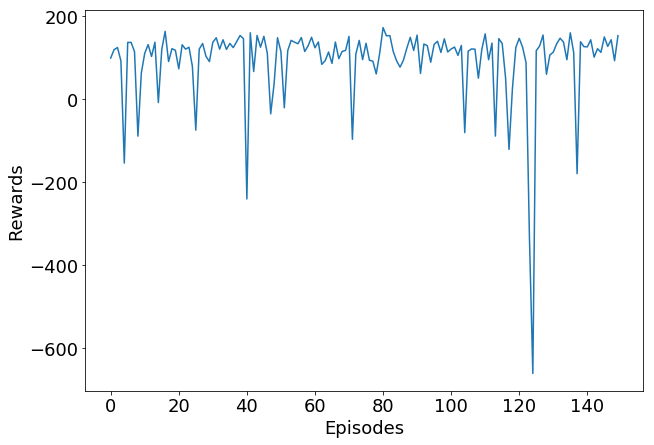

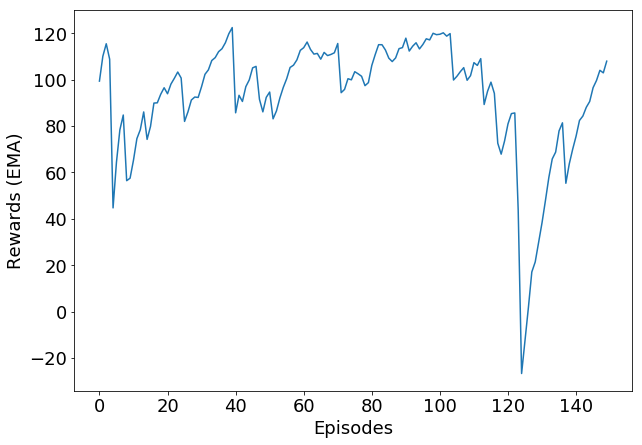

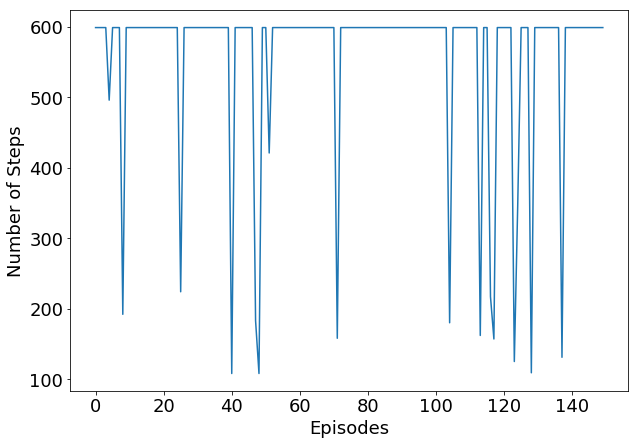

In [18]:
rewards_train['task5'] = []
eps = []
mem_pts.add_task(5)

task5 = gym.make("LunarLander-v2", continuous = True, gravity = -5)
task5.reset(seed = 24)

for ep in range(num_eps):
    if ep % 50 == 0:
        print("Episode: ", ep)
    state = task5.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = task5.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            td3_update(t, batch_size, replay_buffer, False, mem_pts, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break
    eps.append(t)

    rewards_train['task5'].append(ep_reward)

# Save models for next task
prev_Q = ValueNetwork(seed1, state_dim, action_dim, hidden_dim).to(device)
prev_Q.load_state_dict(target_value_net1.state_dict())
prev_Q.eval()

prev_policy = PolicyNetwork(seed3, state_dim, action_dim, hidden_dim).to(device)
prev_policy.load_state_dict(target_policy_net.state_dict())
prev_policy.eval()

print('Task 5 Training Complete')
rewards_task5 = rewards_train['task5']
plot_rewards(rewards_task5)
plot_smoothed(rewards_task5, 0.1)
plot_eps(eps)

## Task 6 (training)
- Gravity: -5
- Wind enabled

Episode:  0
Episode:  50
Episode:  100
Task 6 Training Complete


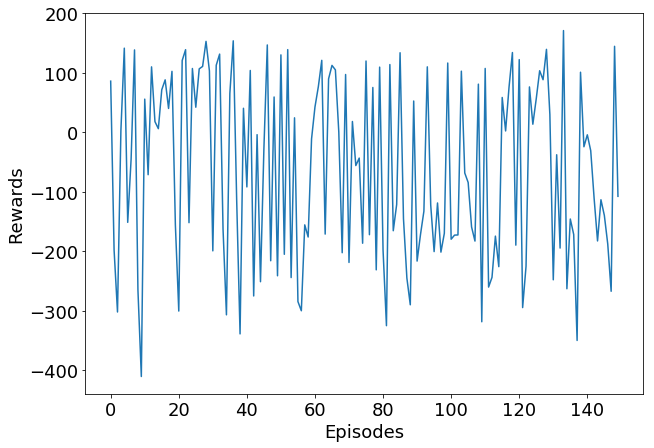

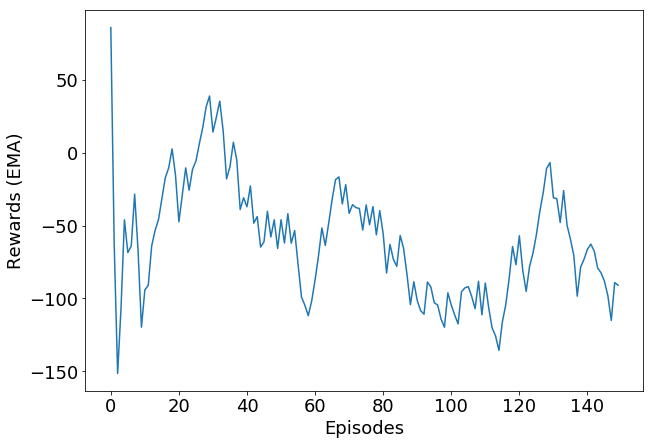

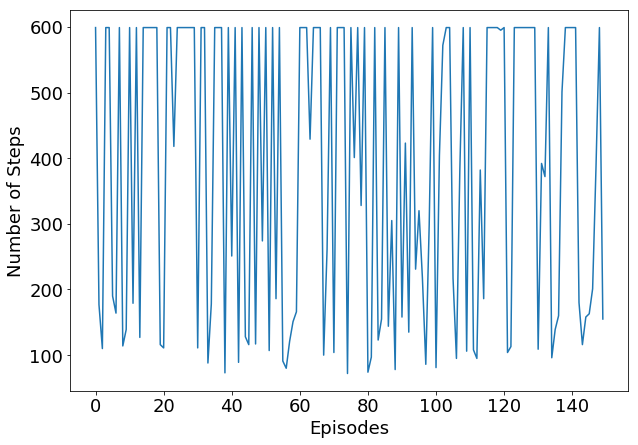

In [19]:
rewards_train['task6'] = []
eps = []
mem_pts.add_task(6)

task6 = gym.make("LunarLander-v2", continuous = True, gravity = -5, enable_wind = True, wind_power = 20)
task6.reset(seed = 24)

for ep in range(num_eps):
    if ep % 50 == 0:
        print("Episode: ", ep)
    state = task6.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        action = noise.get_action(action, t)
        next_state, reward, done, _ = task6.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            td3_update(t, batch_size, replay_buffer, False, mem_pts, prev_Q, prev_policy)
        
        state = next_state
        ep_reward += reward
        
        if done:
            break
    eps.append(t)
            
    rewards_train['task6'].append(ep_reward)

print('Task 6 Training Complete')
rewards_task6 = rewards_train['task6']
plot_rewards(rewards_task6)
plot_smoothed(rewards_task6, 0.1)
plot_eps(eps)

## Task 1 (test)

Task 1 Testing Complete


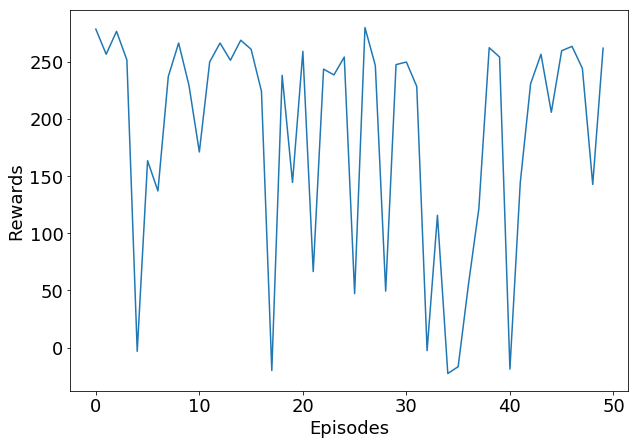

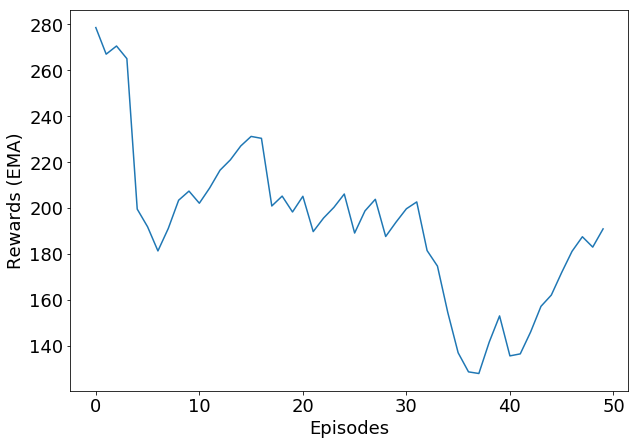

In [20]:
rewards_test['task1'] = []
test_eps = 50

for ep in range(test_eps):
    state = task1.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        next_state, reward, done, _ = task1.step(action)
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test['task1'].append(ep_reward)

print('Task 1 Testing Complete')
rewards_task1 = rewards_test['task1']
plot_rewards(rewards_task1)
plot_smoothed(rewards_task1, 0.1)

In [21]:
# Save video of task1 agent
frames = []
for i in range(2):
    state = task1.reset()
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(task1.render(mode="rgb_array"))
#         time.sleep(0.001)
        action = policy_net.get_action(state)
        next_state, _, done, _ = task1.step(action)        
        state = next_state
        if done:
            break
task1.close()
# save_frames_as_gif(frames, filename='lunar_lander_test_task1_fromp.gif')
# save_frames_as_gif(frames, filename='lunar_lander_test_task1_temp.gif')

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


## Task 2 (test)

Task 2 Testing Complete


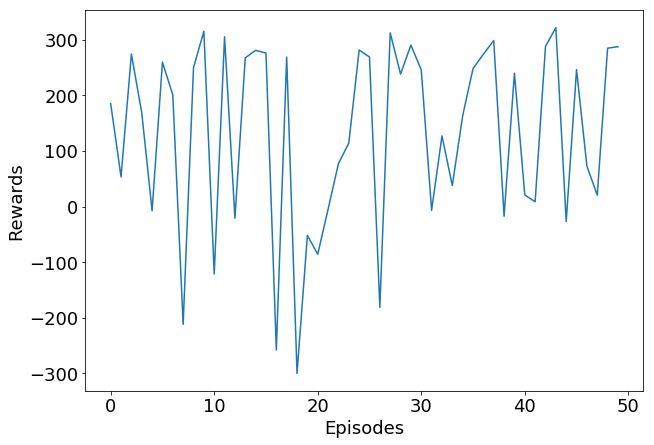

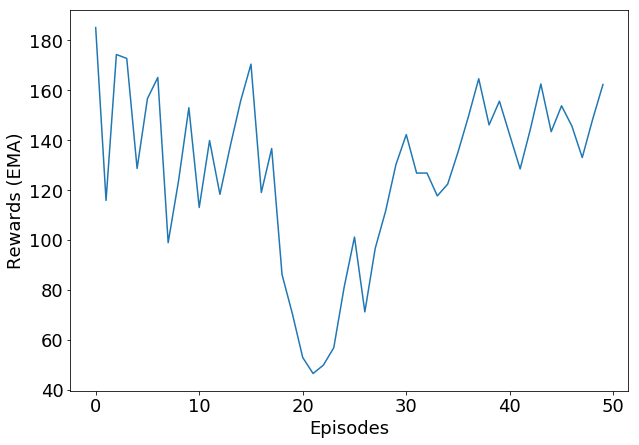

In [22]:
rewards_test['task2'] = []
test_eps = 50

for ep in range(test_eps):
    state = task2.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        next_state, reward, done, _ = task2.step(action)
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test['task2'].append(ep_reward)

print('Task 2 Testing Complete')
rewards_task2 = rewards_test['task2']
plot_rewards(rewards_task2)
plot_smoothed(rewards_task2, 0.1)

In [23]:
# Save video of task2 agent
frames = []
for i in range(2):
    state = task2.reset()
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(task2.render(mode="rgb_array"))
#         time.sleep(0.001)
        action = policy_net.get_action(state)
        next_state, _, done, _ = task2.step(action)        
        state = next_state
        if done:
            break
task2.close()
# save_frames_as_gif(frames, filename='lunar_lander_test_task2_fromp.gif')

## Task 3 (test)

Task 3 Testing Complete


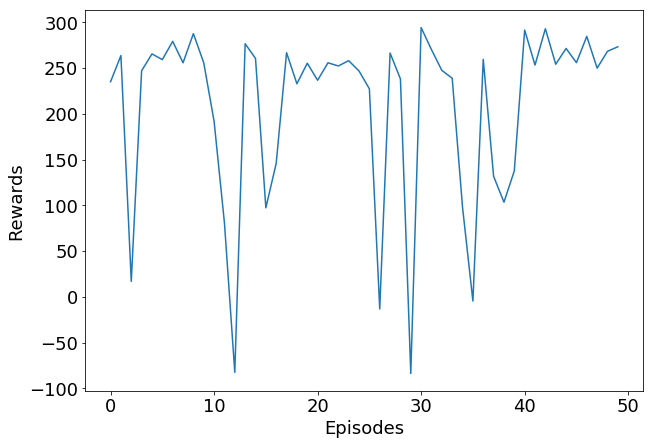

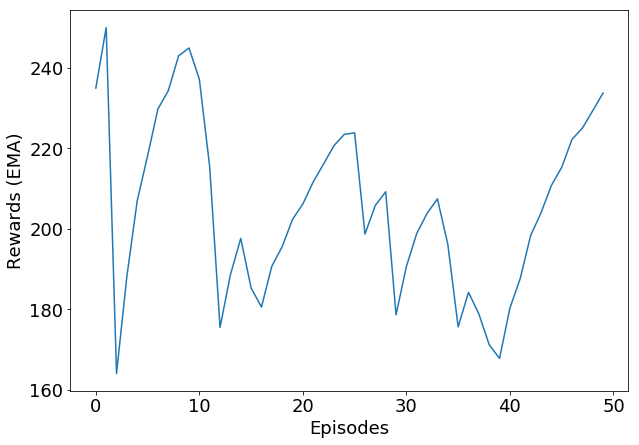

In [24]:
rewards_test['task3'] = []
test_eps = 50

for ep in range(test_eps):
    state = task3.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        next_state, reward, done, _ = task3.step(action)
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test['task3'].append(ep_reward)

print('Task 3 Testing Complete')
rewards_task3 = rewards_test['task3']
plot_rewards(rewards_task3)
plot_smoothed(rewards_task3, 0.1)

In [25]:
# Save video of task3 agent
frames = []
for i in range(2):
    state = task3.reset()
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(task3.render(mode="rgb_array"))
#         time.sleep(0.001)
        action = policy_net.get_action(state)
        next_state, _, done, _ = task3.step(action)        
        state = next_state
        if done:
            break
task3.close()
# save_frames_as_gif(frames, filename='lunar_lander_test_task3_fromp.gif')

## Task 4 (test)

Task 4 Testing Complete


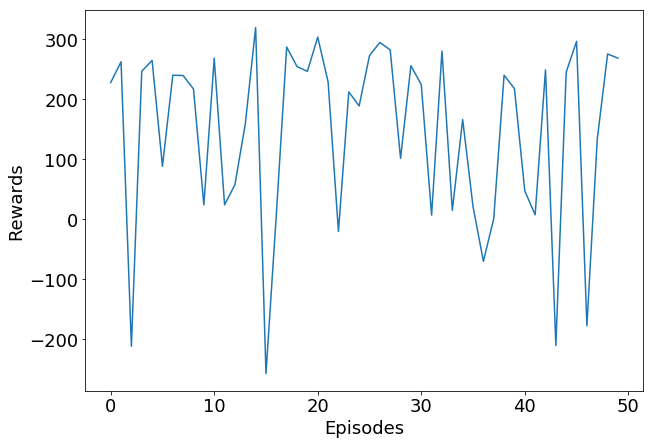

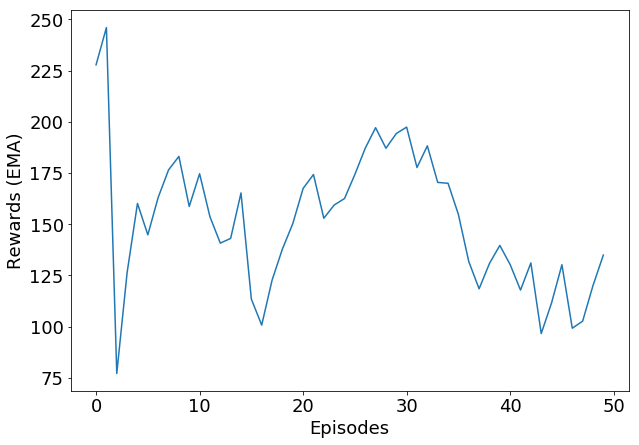

In [26]:
rewards_test['task4'] = []
test_eps = 50

for ep in range(test_eps):
    state = task4.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        next_state, reward, done, _ = task4.step(action)
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test['task4'].append(ep_reward)

print('Task 4 Testing Complete')
rewards_task4 = rewards_test['task4']
plot_rewards(rewards_task4)
plot_smoothed(rewards_task4, 0.1)

In [27]:
# Save video of task4 agent
frames = []
for i in range(2):
    state = task4.reset()
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(task4.render(mode="rgb_array"))
#         time.sleep(0.001)
        action = policy_net.get_action(state)
        next_state, _, done, _ = task4.step(action)        
        state = next_state
        if done:
            break
task4.close()
# save_frames_as_gif(frames, filename='lunar_lander_test_task4_fromp.gif')

## Task 5 (test)

Task 5 Testing Complete


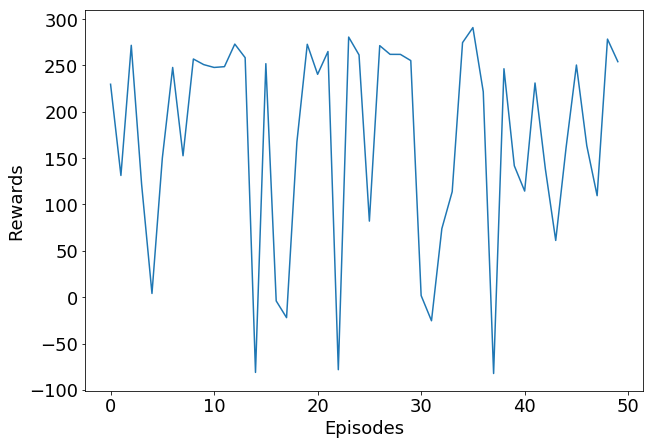

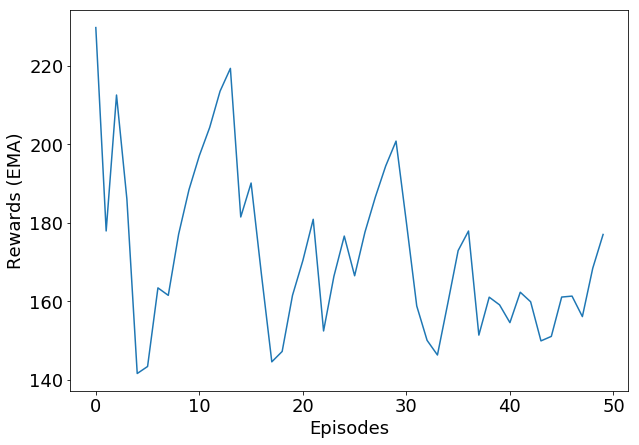

In [28]:
rewards_test['task5'] = []
test_eps = 50

for ep in range(test_eps):
    state = task5.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        next_state, reward, done, _ = task5.step(action)
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test['task5'].append(ep_reward)

print('Task 5 Testing Complete')
rewards_task5 = rewards_test['task5']
plot_rewards(rewards_task5)
plot_smoothed(rewards_task5, 0.1)

In [29]:
# Save video of task5 agent
frames = []
for i in range(2):
    state = task5.reset()
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(task5.render(mode="rgb_array"))
#         time.sleep(0.001)
        action = policy_net.get_action(state)
        next_state, _, done, _ = task5.step(action)        
        state = next_state
        if done:
            break
task5.close()
# save_frames_as_gif(frames, filename='lunar_lander_test_task5_fromp.gif')

## Task 6 (test)

Task 6 Testing Complete


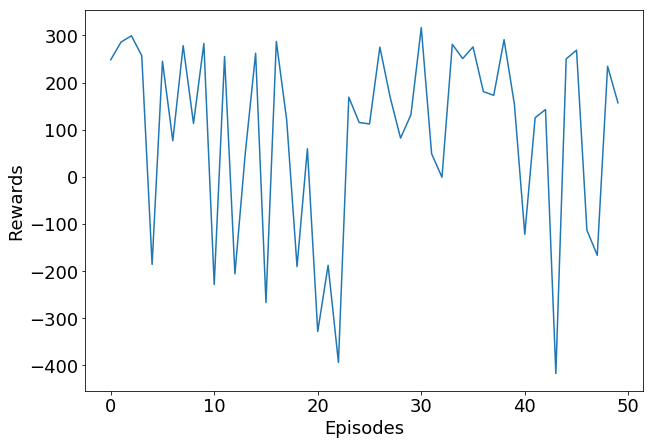

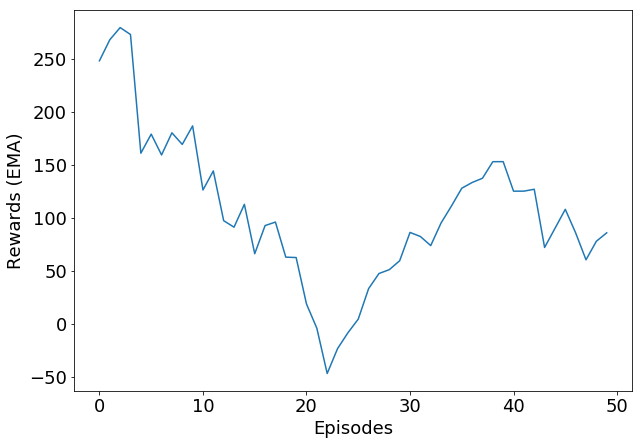

In [30]:
rewards_test['task6'] = []
test_eps = 50

for ep in range(test_eps):
    state = task6.reset()
    ep_reward = 0
    for t in range(max_steps):
        action = policy_net.get_action(state)
        next_state, reward, done, _ = task6.step(action)
        state = next_state
        ep_reward += reward
        
        if done:
            break

    rewards_test['task6'].append(ep_reward)

print('Task 6 Testing Complete')
rewards_task6 = rewards_test['task6']
plot_rewards(rewards_task6)
plot_smoothed(rewards_task6, 0.1)

In [31]:
# Save video of task6 agent
frames = []
for i in range(2):
    state = task6.reset()
    for t in range(max_steps):
        #Render to frames buffer
        frames.append(task6.render(mode="rgb_array"))
#         time.sleep(0.001)
        action = policy_net.get_action(state)
        next_state, _, done, _ = task6.step(action)        
        state = next_state
        if done:
            break
task6.close()
# save_frames_as_gif(frames, filename='lunar_lander_test_task6_fromp.gif')

## Save Data

In [32]:
train_df = pd.DataFrame(rewards_train)
# train_df.to_csv('./Data/train_rewards_lunar_lander_fromp.csv')

## Plot Rewards for All Trips

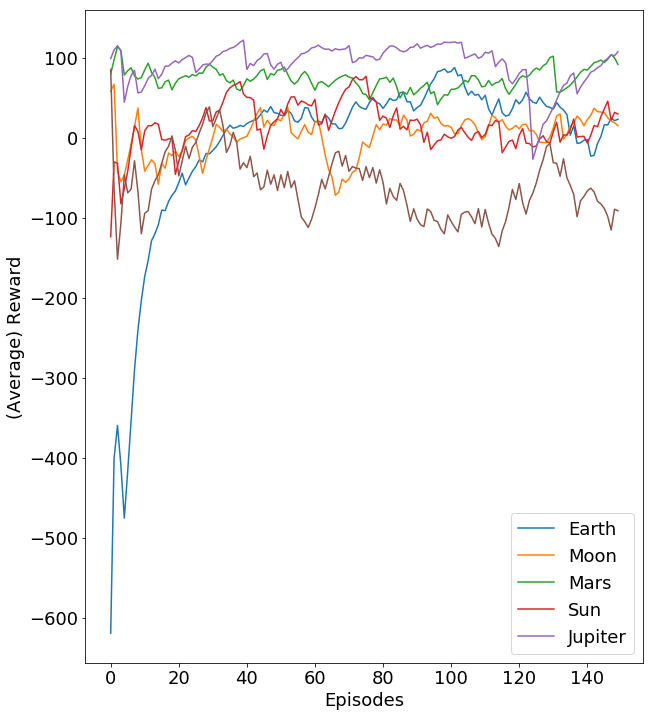

In [33]:
figure, axis = plt.subplots(1, 1)
axis.plot(train_df.ewm(alpha = 0.1).mean())
axis.set_xlabel("Episodes")
axis.set_ylabel("(Average) Reward")
axis.legend(['Earth', "Moon", "Mars", "Sun", "Jupiter"])
# axis.set_ylim(-1100, 0)
fig = plt.gcf()
fig.set_size_inches(10, 12)
# plt.savefig("./Visualizations/train_lunar_lander_fromp.jpg")
plt.show()

### Test Results

In [34]:
test_df = pd.DataFrame(rewards_test)
train_df = pd.DataFrame(rewards_train)
# test_df.to_csv('./Data/test_rewards_lunar_lander_fromp.csv')

In [35]:
print("****TRAINING RESULTS (FROMP)****")
print(train_df.tail(50).mean())
print("****TEST RESULTS (FROMP)****")
print(test_df.mean())

****TRAINING RESULTS (FROMP)****
task1    24.167007
task2    15.700423
task3    84.278934
task4    11.780563
task5    75.706084
task6   -78.541812
dtype: float64
****TEST RESULTS (FROMP)****
task1    186.352154
task2    131.658700
task3    208.850441
task4    146.406606
task5    171.017547
task6     90.369929
dtype: float64
